In [11]:
from __future__ import print_function
import argparse
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from PIL import Image
from torchvision.transforms import ToTensor
from math import log10


from torch.utils.data import DataLoader
from dataset.data import get_training_set, get_test_set

import numpy as np
import cv2
from matplotlib import pyplot as plt

In [12]:
def downscale(filepath, factor) :
    img = Image.open(filepath)
    width, height = img.size
    newWidth = width // factor
    newHeight = height // factor
    img = im.resize((newWidth, newHeight))
    img.save(filepath)

In [13]:
def blurrify(filepath, blurWidth, blurHeight) : 
    img = cv2.imread(filepath)
    blur = cv2.blur(img,(blurWidth, blurHeight))
    cv2.imwrite(filepath,blur)
    

In [22]:
# ===========================================================
# argument settings
# ===========================================================

inputFilePath = '/Users/glchau/Downloads/Sam_highres.jpg'
modelPath = 'model_path.pth'
outputPath = 'test.jpg'
upscaleFactor = 4
batchSize = 1
criterion = torch.nn.MSELoss()

In [23]:
# ===========================================================
# input image setting
# ===========================================================
GPU_IN_USE = torch.cuda.is_available()
myBlurryFile = 'blurry.jpg'

# Load file 
im = Image.open(inputFilePath)
width, height = im.size
im.save(myBlurryFile)

# Blur the image and save
blurrify(myBlurryFile, width // 50, height // 50)

# Downscale the image by the upscale factor
downscale(myBlurryFile, upscaleFactor)

#print("Done blurrifying image " + myBlurryFile)

In [24]:
# ===========================================================
# load images
# ===========================================================

# Load the blurry image
img = Image.open(myBlurryFile).convert('YCbCr')
y, cb, cr = img.split()

# Get the original image
original_img = Image.open(inputFilePath).convert('YCbCr')
original_y, original_cb, original_cr = original_img.split()

In [25]:
# ===========================================================
# model import & setting
# ===========================================================
device = torch.device('cuda' if GPU_IN_USE else 'cpu')
model = torch.load(modelPath, map_location=lambda storage, loc: storage)
#model = model.to(device)
data = (ToTensor()(y)).view(1, -1, y.size[1], y.size[0])
#data = data.to(device)

if GPU_IN_USE:
    cudnn.benchmark = True


In [26]:
# ===========================================================
# output and save image
# ===========================================================
out = model(data)
out = out.cpu()
out_img_y = out.data[0].numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')

out_img_cb = cb.resize(out_img_y.size, Image.BICUBIC)
out_img_cr = cr.resize(out_img_y.size, Image.BICUBIC)
out_img = Image.merge('YCbCr', [out_img_y, out_img_cb, out_img_cr]).convert('RGB')

out_img.save(outputPath)
#print('output image saved to ', outputPath)



In [48]:
# ===========================================================
# print metrics
# ===========================================================
original_data = (ToTensor()(original_y)).view(1, -1, original_y.size[1], original_y.size[0])

prediction = model(data)

if(prediction.shape[2] > original_data.shape[2]) :
    prediction = prediction[:, :, :original_data.shape[2], :]
if(prediction.shape[2] < original_data.shape[2]) :
    original_data = original_data[:, :, :prediction.shape[2], :]
if(prediction.shape[3] > original_data.shape[3]) :
    prediction = prediction[:, :, :, :original_data.shape[3]]
if(prediction.shape[3] < original_data.shape[3]) :
    original_data = original_data[:, :, :, :prediction.shape[3]]

mse = criterion(prediction, original_data)
psnr = 10 * log10(1 / mse.item())
print("psnr between original = " + str(psnr))

psnr between original = 27.17508420352428


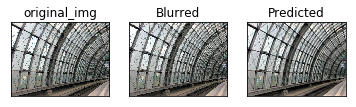

In [10]:
# ===========================================================
# show images
# ===========================================================
plt.subplot(131),plt.imshow(original_img),plt.title('original_img')
plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img),plt.title('Blurred')
plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(out_img),plt.title('Predicted')
plt.xticks([]), plt.yticks([])
plt.show()

